## Bit of basic image analysis for 2D scalar field - eg vorticity or speed of a fluid


RPS, 2024

below written to work with vorticity but will work with any 2D scalar field, eg speed of flow, but for that will need threshold adjusting.

Below uses "cv2" which comes from [opencv](https://opencv.org/). See [here](https://docs.opencv.org/4.x/da/df6/tutorial_py_table_of_contents_setup.html) for an intro and help installing. On a Uni linux machine you will need to install opencv, try opening a terminal and typing

pip install --user opencv-python

cv2 aka opencv is a very common Python package doing something many many people need to do - analyse images - so if you have a problem just Google etc it and look at stack overflow etc. Also there are many many webpages, YouTube videos etc etc on cv

**NB It is important to note that image analysis is just analysis of arrays of numbers, a gray image is just a 2D array of numbers, like the numpy arrays you are used to**

In [1]:
#from matplotlib import image
from matplotlib import pyplot as plt
import numpy as np
import cv2
#from skimage import io
#
#from google.colab import drive
#drive.mount('/content/drive')

Read in ("pickled") file with vorticity array... NB pickle is just an efficient way of saving numpy arrays etc for reading in by another program. Usually in science we have at least two Python programs, one that generates data and another that analyses the data.

NB code can be edited to make it work with any other scalar field

reading in  ./data/vort1019900.npz
['vorticity', 'Re', 'time', 'allow_pickle']
read in vorticity array of size (460, 180)
data at time  19.9  from run at Reynolds number  100
vorticity ranges from  -0.047757761359525516  to  0.049199949856568864


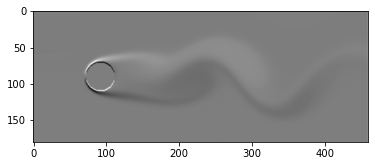

In [2]:
filename='./data/vort1019900.npz'

print('reading in ',filename)
# with hopefully close .npz file at end
with np.load(filename) as npzfile:
    print(npzfile.files)
    vorticity=npzfile['vorticity']
    time=npzfile['time']
    Re=npzfile['Re']
print('read in vorticity array of size',vorticity.shape)
print('data at time ',time,' from run at Reynolds number ', Re)
min_vort=np.amin(vorticity)
max_vort=np.amax(vorticity)
print('vorticity ranges from ',min_vort,' to ',max_vort)
plt.imshow(np.transpose(vorticity),cmap='gray')
plt.show()

Slice array to remove the disc - so just looking at vortices downstream.

vorticity array now of size (310, 180)


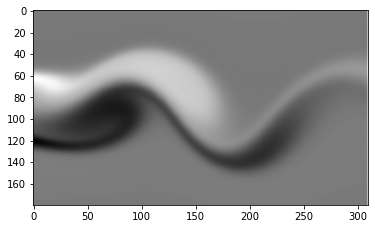

In [3]:
vorticity=vorticity[150:,:]
print('vorticity array now of size',vorticity.shape)
plt.imshow(np.transpose(vorticity),cmap='gray')
plt.show()

Get histogram of array values to see what distribution is. This helps with picking a value for the threshold.

55800  pixels


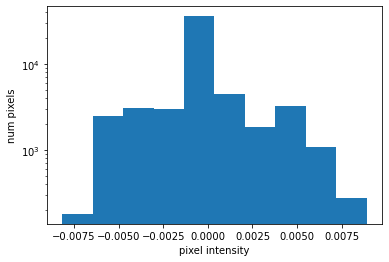

In [4]:
array1d=vorticity.flatten()
print(len(array1d),' pixels')
plt.hist(array1d)
plt.xlabel('pixel intensity')
plt.ylabel('num pixels')
plt.yscale('log')

Below uses cv2.threshold function to create an array of the same size as the vorticity array but with all array values either 1, for vorticity value above (not equal to) the threshold, or 0, for vorticity value below the threshold.

Note this threshold value is selected by trial and error, feel free to play around with the number.



initially counting all pixels with intensity greater than  0.002  as in fibres
float64
uint8
(310, 180)


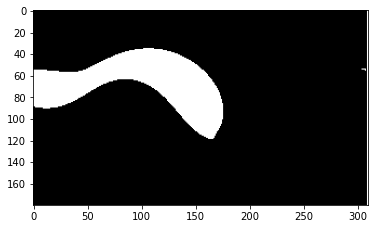

note image now binary, black/white


In [5]:
threshold_value=0.002
print('initially counting all pixels with intensity greater than ',threshold_value,' as in fibres')
ret,binary_image = cv2.threshold(vorticity,threshold_value,1,cv2.THRESH_BINARY)
#
print(binary_image.dtype)
binary_image=binary_image.astype('uint8')
print(binary_image.dtype)
print(binary_image.shape)
# display the array of pixels as an image
plt.imshow(np.transpose(binary_image),cmap='gray')#, vmin = 0, vmax = 255)
plt.show()
print('note image now binary, black/white')

Now use the clustering algorithm from OpenCV.

The clustering algorithm from Open CV works to find patches of array elements above the threshold, i.e., works to connect clusters of **white** pixels. So image should be disconnected clusters of white pixels in a black background. Patches of black pixels in a continuous white background will not work, I think.

cv2.bitwise_not is probably the cv command you need if you need to flip the image.




found  3  clusters, ie separate sets of above threshold pixels


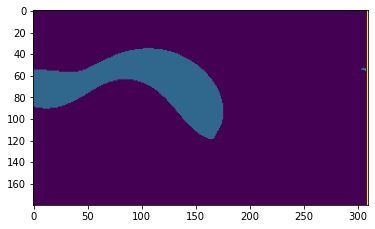

(310, 180)


In [6]:
numLabels, labels,stats,centroids = cv2.connectedComponentsWithStats(binary_image)
print('found ',numLabels -1, \
      ' clusters, ie separate sets of above threshold pixels')
plt.imshow(np.transpose(labels))
plt.show()
print(labels.shape)


Below loops over clusters greater than some threshold size, printing out size and location

In [7]:
min_cluster_size=100
# loop over the number of unique connected component labels, skipping
# over the first label (as label zero is the background)
for i in range(1, numLabels):
# extract the connected component statistics for the current
# label
   x = stats[i, cv2.CC_STAT_LEFT]
   y = stats[i, cv2.CC_STAT_TOP]
   w = stats[i, cv2.CC_STAT_WIDTH]
   h = stats[i, cv2.CC_STAT_HEIGHT]
   area = stats[i, cv2.CC_STAT_AREA]
   if(area>min_cluster_size):
       print('cluster ',i,' has area = ',area, \
             ' located at x',round(centroids[i,0],1),' y ', \
             round(centroids[i,1],1))

cluster  1  has area =  6434  located at x 68.7  y  99.4
cluster  3  has area =  180  located at x 89.5  y  309.0


Cell below may or may not needed, it just removes clusters below a specified size ...

removing connected clusters of pixels with less than  100  pixels
removing tiny possible fibre of  5  pixels
number of clusters remaining  2


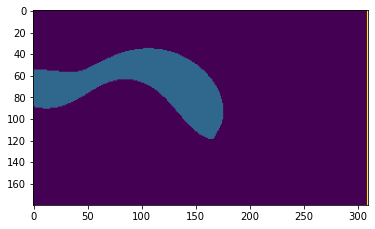

In [8]:
num_clusters=numLabels-1
print('removing connected clusters of pixels with less than ',min_cluster_size,' pixels')
for i in range(1,numLabels):
    pts =  np.where(labels == i)
#    print(i,len(pts[0]))#,len(pts[1]))
    if len(pts[0]) < min_cluster_size:
        labels[pts] = 0
        num_clusters=num_clusters-1
        print('removing tiny possible fibre of ',len(pts[0]),' pixels')

print('number of clusters remaining ',num_clusters)
plt.imshow(np.transpose(labels))#,cmap='gray')#, vmin = 0, vmax = 255)
plt.show()